In [1]:
from dataset import BKG, SIG, AtlasDataset
from loss_functions import mse_loss, mae_loss
from preprocess import train_val_test_split, normalize

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

2023-08-11 11:03:58.486612: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-11 11:03:58.597395: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 11:03:59.275734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from typing import List

class AutoEncoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, arch: List[int]):
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.arch = arch

        if len(arch) == 0:
            raise ValueError("Encoder architecture must have at least one layer")

        if latent_dim >= arch[-1]:
            raise ValueError("Latent dimension must be smaller than the last encoder layer")

        self.encoder = self._encoder()
        self.decoder = self._decoder()

    def _encoder(self) -> nn.Sequential:
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, self.arch[0]),
            nn.ReLU()
        )

        for i in range(1, len(self.arch)):
            self.encoder.add_module(f"fc({i})", nn.Linear(self.arch[i - 1], self.arch[i]))
            self.encoder.add_module(f"A({i})", nn.ReLU())

        self.encoder.add_module("encoder_output", nn.Linear(self.arch[-1], self.latent_dim))

        return self.encoder

    def _decoder(self) -> nn.Sequential:
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.arch[-1]),
            nn.ReLU()
        )

        for i in range(len(self.arch) - 1, 0, -1):
            self.decoder.add_module(f"fc({i})", nn.Linear(self.arch[i], self.arch[i - 1]))
            self.decoder.add_module(f"A({i})", nn.ReLU())

        self.decoder.add_module("decoder_output", nn.Linear(self.arch[0], self.input_dim))

        return self.decoder

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class EarlyStopping:
    def __init__(self, tolerance=5):

        self.tolerance = tolerance
        self.min_validation = np.Inf
        self.counter = 0
        self.early_stop = False
        self.was_triggered = False

    def __call__(self, validation_loss):
        if self.was_triggered:
            self.early_stop = False
            return

        if validation_loss > self.min_validation:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True
                self.was_triggered = True
        else:
            self.min_validation = validation_loss
            self.counter = 0

In [4]:
bkg = pd.read_hdf("data/bkg_pythia_sanitised_features.h5")
sig = pd.read_hdf("data/fcnc_pythia_sanitised_features.h5")

In [5]:
train, val, test = train_val_test_split(bkg, sig, sample_size=100_000)

scaler = StandardScaler()
x_train, y_train, w_train = normalize(train, scaler, is_train=True)
x_val, y_val, w_val = normalize(val, scaler)
x_test, y_test, w_test = normalize(test, scaler)

In [6]:
print("Sample sizes:")
print(f"\tTrain      - {len(train)}")
print(f"\tTest       - {len(test)}")
print(f"\tValidation - {len(val)}")

print("\nMean, Std and Weights sum (after normalization):")
print(f"\tTrain:")
print(f"\t\tX - {x_train.mean()} +- {x_train.std()}")
print(f"\t\tY - {y_train.mean()} +- {y_train.std()}")
print(f"\t\tW - Bkg: {w_train[y_train == BKG].sum()}, Sig: {w_train[y_train == SIG].sum()}")
print(f"\tTest:")
print(f"\t\tX - {x_test.mean()} +- {x_test.std()}")
print(f"\t\tY - {y_test.mean()} +- {y_test.std()}")
print(f"\t\tW - Bkg: {w_test[y_test == BKG].sum()}, Sig: {w_test[y_test == SIG].sum()}")
print(f"\tValidation:")
print(f"\t\tX - {x_val.mean()} +- {x_val.std()}")
print(f"\t\tY - {y_val.mean()} +- {y_val.std()}")
print(f"\t\tW - Bkg: {w_val[y_val == BKG].sum()}, Sig: {w_val[y_val == SIG].sum()}")

Sample sizes:
	Train      - 33333
	Test       - 33334
	Validation - 33333

Mean, Std and Weights sum (after normalization):
	Train:
		X - -9.796516960330134e-18 +- 1.0
		Y - 0.08283082830828309 +- 0.27562634523943247
		W - Bkg: 16666.500000000004, Sig: 16666.5
	Test:
		X - -0.0011236642348100745 +- 1.0023429851382641
		Y - 0.08285834283314333 +- 0.27566798482248284
		W - Bkg: 16667.0, Sig: 16666.999999999996
	Validation:
		X - 0.0012283782262771125 +- 1.00117155447564
		Y - 0.08283082830828309 +- 0.27562634523943247
		W - Bkg: 16666.5, Sig: 16666.5


In [7]:
train_dataset = AtlasDataset(x_train[y_train == BKG], y_train[y_train == BKG], w_train[y_train == BKG])
val_dataset = AtlasDataset(x_val[y_val == BKG], y_val[y_val == BKG], w_val[y_val == BKG])
test_dataset = AtlasDataset(x_test, y_test, w_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=16)

In [8]:
model = AutoEncoder(x_train.shape[1], 6, [64, 32, 16]).to(device=device)
loss_fn = mse_loss

In [9]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=47, out_features=64, bias=True)
    (1): ReLU()
    (fc(1)): Linear(in_features=64, out_features=32, bias=True)
    (A(1)): ReLU()
    (fc(2)): Linear(in_features=32, out_features=16, bias=True)
    (A(2)): ReLU()
    (encoder_output): Linear(in_features=16, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): ReLU()
    (fc(2)): Linear(in_features=16, out_features=32, bias=True)
    (A(2)): ReLU()
    (fc(1)): Linear(in_features=32, out_features=64, bias=True)
    (A(1)): ReLU()
    (decoder_output): Linear(in_features=64, out_features=47, bias=True)
  )
)

## Pre Training Test

In [10]:
x_orig = []
x_recs = []
losses = []


model.eval()
with torch.no_grad():
    for i, (x, y, w) in enumerate(test_loader):
        x = x.to(device)
        y = y.to(device)
        w = w.to(device)

        x_rec = model(x)
        loss = torch.pow(x - x_rec, 2)

        x_orig.append(x)
        x_recs.append(x_rec)
        losses.append(loss)

x_orig = torch.cat(x_orig).cpu().detach().numpy()
x_recs = torch.cat(x_recs).cpu().detach().numpy()
losses = torch.cat(losses).sum(dim=1).cpu().detach().numpy()

print(x_orig.shape, x_recs.shape, losses.shape)

features = train.drop(columns=['is_signal', 'weight']).columns
df_orig = pd.DataFrame(x_orig, columns=features)
df_recs = pd.DataFrame(x_recs, columns=features)

(33334, 47) (33334, 47) (33334,)


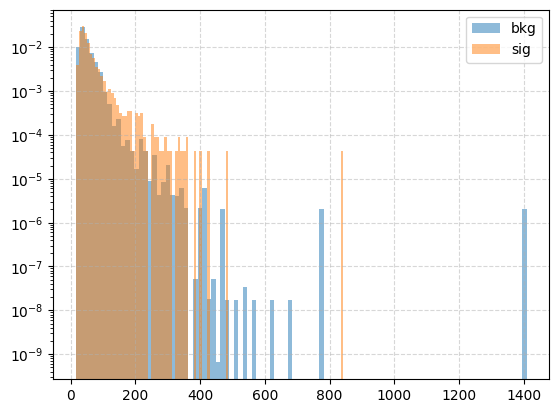

In [11]:
plt.clf()
plt.hist(losses[y_test == BKG], bins=100, density=True, alpha=0.5, label='bkg', weights=w_test[y_test == BKG])
plt.hist(losses[y_test == SIG], bins=100, density=True, alpha=0.5, label='sig', weights=w_test[y_test == SIG])
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()

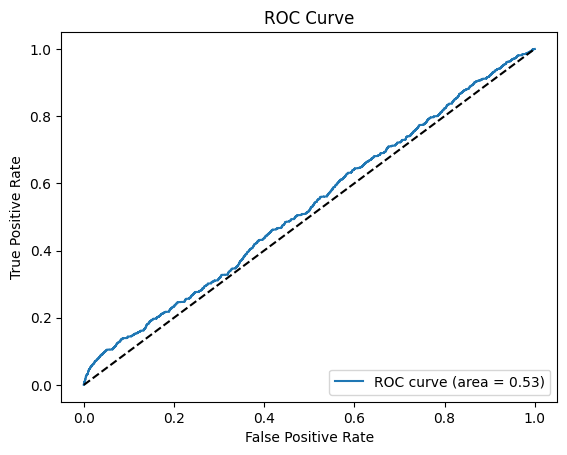

In [12]:
fpr, tpr, _ = roc_curve(y_test, losses, sample_weight=w_test)
score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

<Figure size 640x480 with 0 Axes>

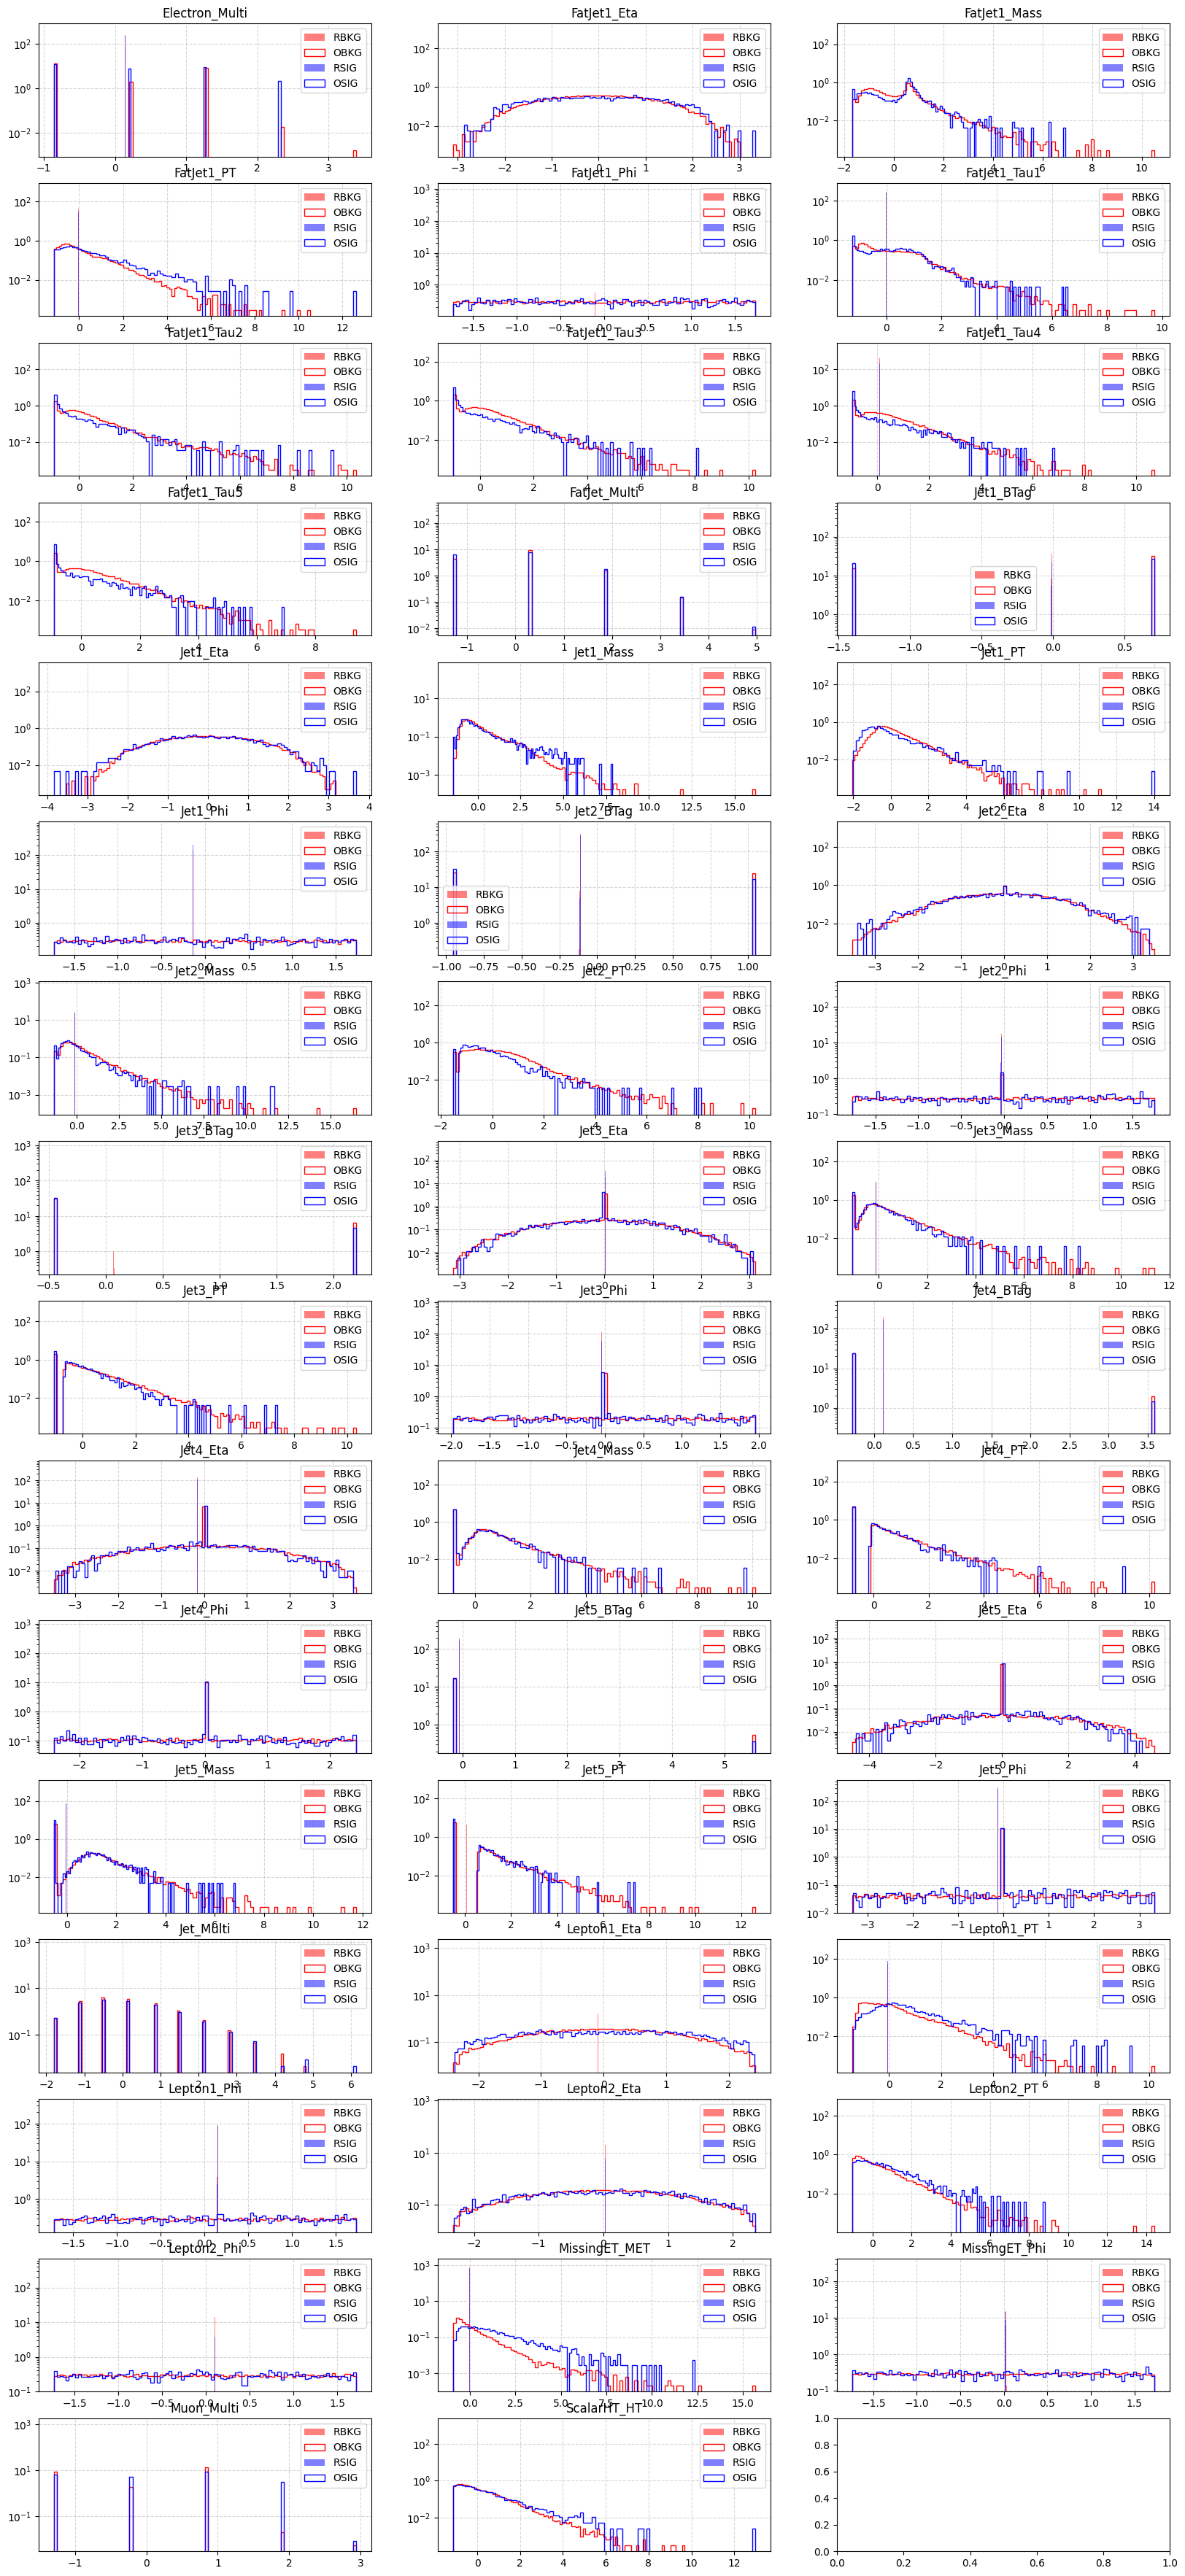

In [13]:
num_cols = 3
num_rows = len(features)//num_cols + 1

plt.clf()
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 240*num_cols//num_rows))
for idx, feature in enumerate(features):
    ax[idx//num_cols, idx%num_cols].grid(True, linestyle='--', alpha=0.5)
    ax[idx//num_cols, idx%num_cols].set_title(feature)
    ax[idx//num_cols, idx%num_cols].hist(df_recs[feature][y_test == BKG], bins=100, density=True, alpha=0.5, label="RBKG", color='red')
    ax[idx//num_cols, idx%num_cols].hist(df_orig[feature][y_test == BKG], bins=100, density=True, label="OBKG", histtype='step', color='red')
    ax[idx//num_cols, idx%num_cols].hist(df_recs[feature][y_test == SIG], bins=100, density=True, alpha=0.5, label="RSIG", color='blue')
    ax[idx//num_cols, idx%num_cols].hist(df_orig[feature][y_test == SIG], bins=100, density=True, label="OSIG", histtype='step', color='blue')
    ax[idx//num_cols, idx%num_cols].set_yscale("log")
    ax[idx//num_cols, idx%num_cols].legend()

plt.show()

## Train and Validation

Saving model at epoch 132


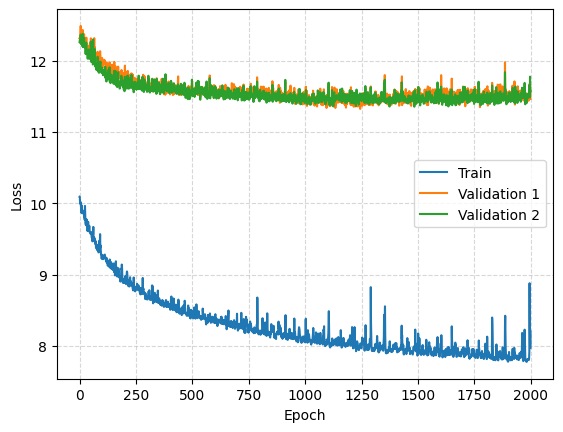

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
callback = EarlyStopping(tolerance=25)

# Train the model
train_losses = []
val_losses_1 = []
val_losses_2 = []
for epoch in range(2000):
    model.train()
    train_epoch_loss = 0
    for batch, (X, _, w) in enumerate(train_loader):
        X = X.to(device)
        w = w.to(device)

        X_preds = model(X)

        loss = loss_fn(X_preds, X, w).mean()
        train_epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_epoch_loss / len(train_loader)

    model.eval()
    val_epoch_loss_1 = 0
    val_epoch_loss_2 = 0
    with torch.no_grad():
        for batch, (X, _, w) in enumerate(val_loader):
            X = X.to(device)
            w = w.to(device)

            X_preds = model(X)

            loss = loss_fn(X_preds, X, w).mean()
            if batch % 2 == 0:
                val_epoch_loss_1 += loss.item()
            else:
                val_epoch_loss_2 += loss.item()

    val_loss_1 = val_epoch_loss_1 / (len(val_loader) // 2)
    val_loss_2 = val_epoch_loss_2 / (len(val_loader) // 2)

    callback(val_loss_1)
    if callback.early_stop:
        print(f"Saving model at epoch {epoch}")
        torch.save(model.state_dict(), 'ae_model.pth')
    val_losses_1.append(val_loss_1)

    callback(val_loss_2)
    if callback.early_stop:
        print(f"Saving model at epoch {epoch}")
        torch.save(model.state_dict(), 'ae_model.pth')
    val_losses_2.append(val_loss_2)

    train_losses.append(train_loss)

plt.plot(train_losses, label='Train')
plt.plot(val_losses_1, label='Validation 1')
plt.plot(val_losses_2, label='Validation 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Post Training Test

In [21]:
import os
if os.path.exists("ae_model.pth"):
    model.load_state_dict(torch.load("ae_model.pth"))

In [22]:
x_orig = []
x_recs = []
losses = []


model.eval()
with torch.no_grad():
    for i, (x, y, w) in enumerate(test_loader):
        x = x.to(device)
        y = y.to(device)
        w = w.to(device)

        x_rec = model(x)
        loss = torch.pow(x - x_rec, 2)

        x_orig.append(x)
        x_recs.append(x_rec)
        losses.append(loss)

x_orig = torch.cat(x_orig).cpu().detach().numpy()
x_recs = torch.cat(x_recs).cpu().detach().numpy()
losses = torch.cat(losses).sum(dim=1).cpu().detach().numpy()

print(x_orig.shape, x_recs.shape, losses.shape)

features = train.drop(columns=['is_signal', 'weight']).columns
df_orig = pd.DataFrame(x_orig, columns=features)
df_recs = pd.DataFrame(x_recs, columns=features)

(33334, 47) (33334, 47) (33334,)


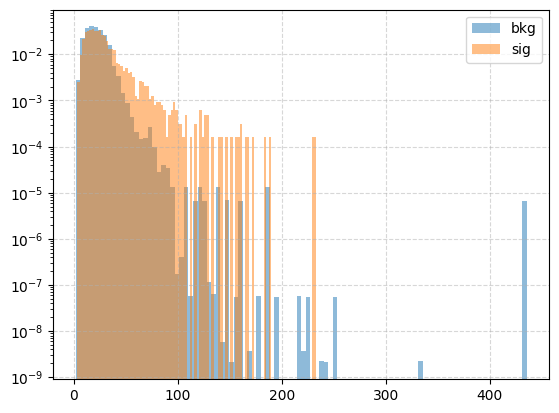

In [23]:
plt.clf()
plt.hist(losses[y_test == BKG], bins=100, density=True, alpha=0.5, label='bkg', weights=w_test[y_test == BKG])
plt.hist(losses[y_test == SIG], bins=100, density=True, alpha=0.5, label='sig', weights=w_test[y_test == SIG])
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()

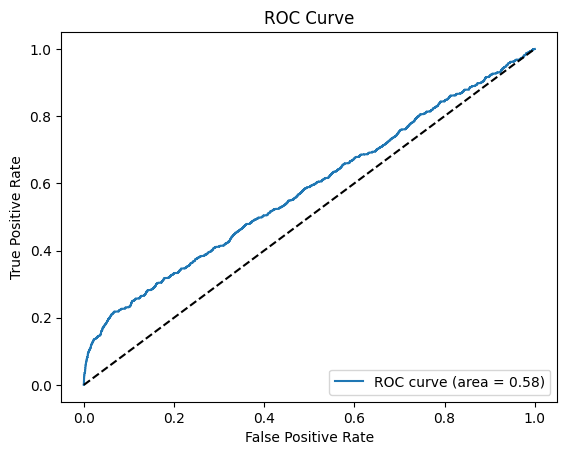

In [24]:
fpr, tpr, _ = roc_curve(y_test, losses, sample_weight=w_test)
score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

<Figure size 640x480 with 0 Axes>

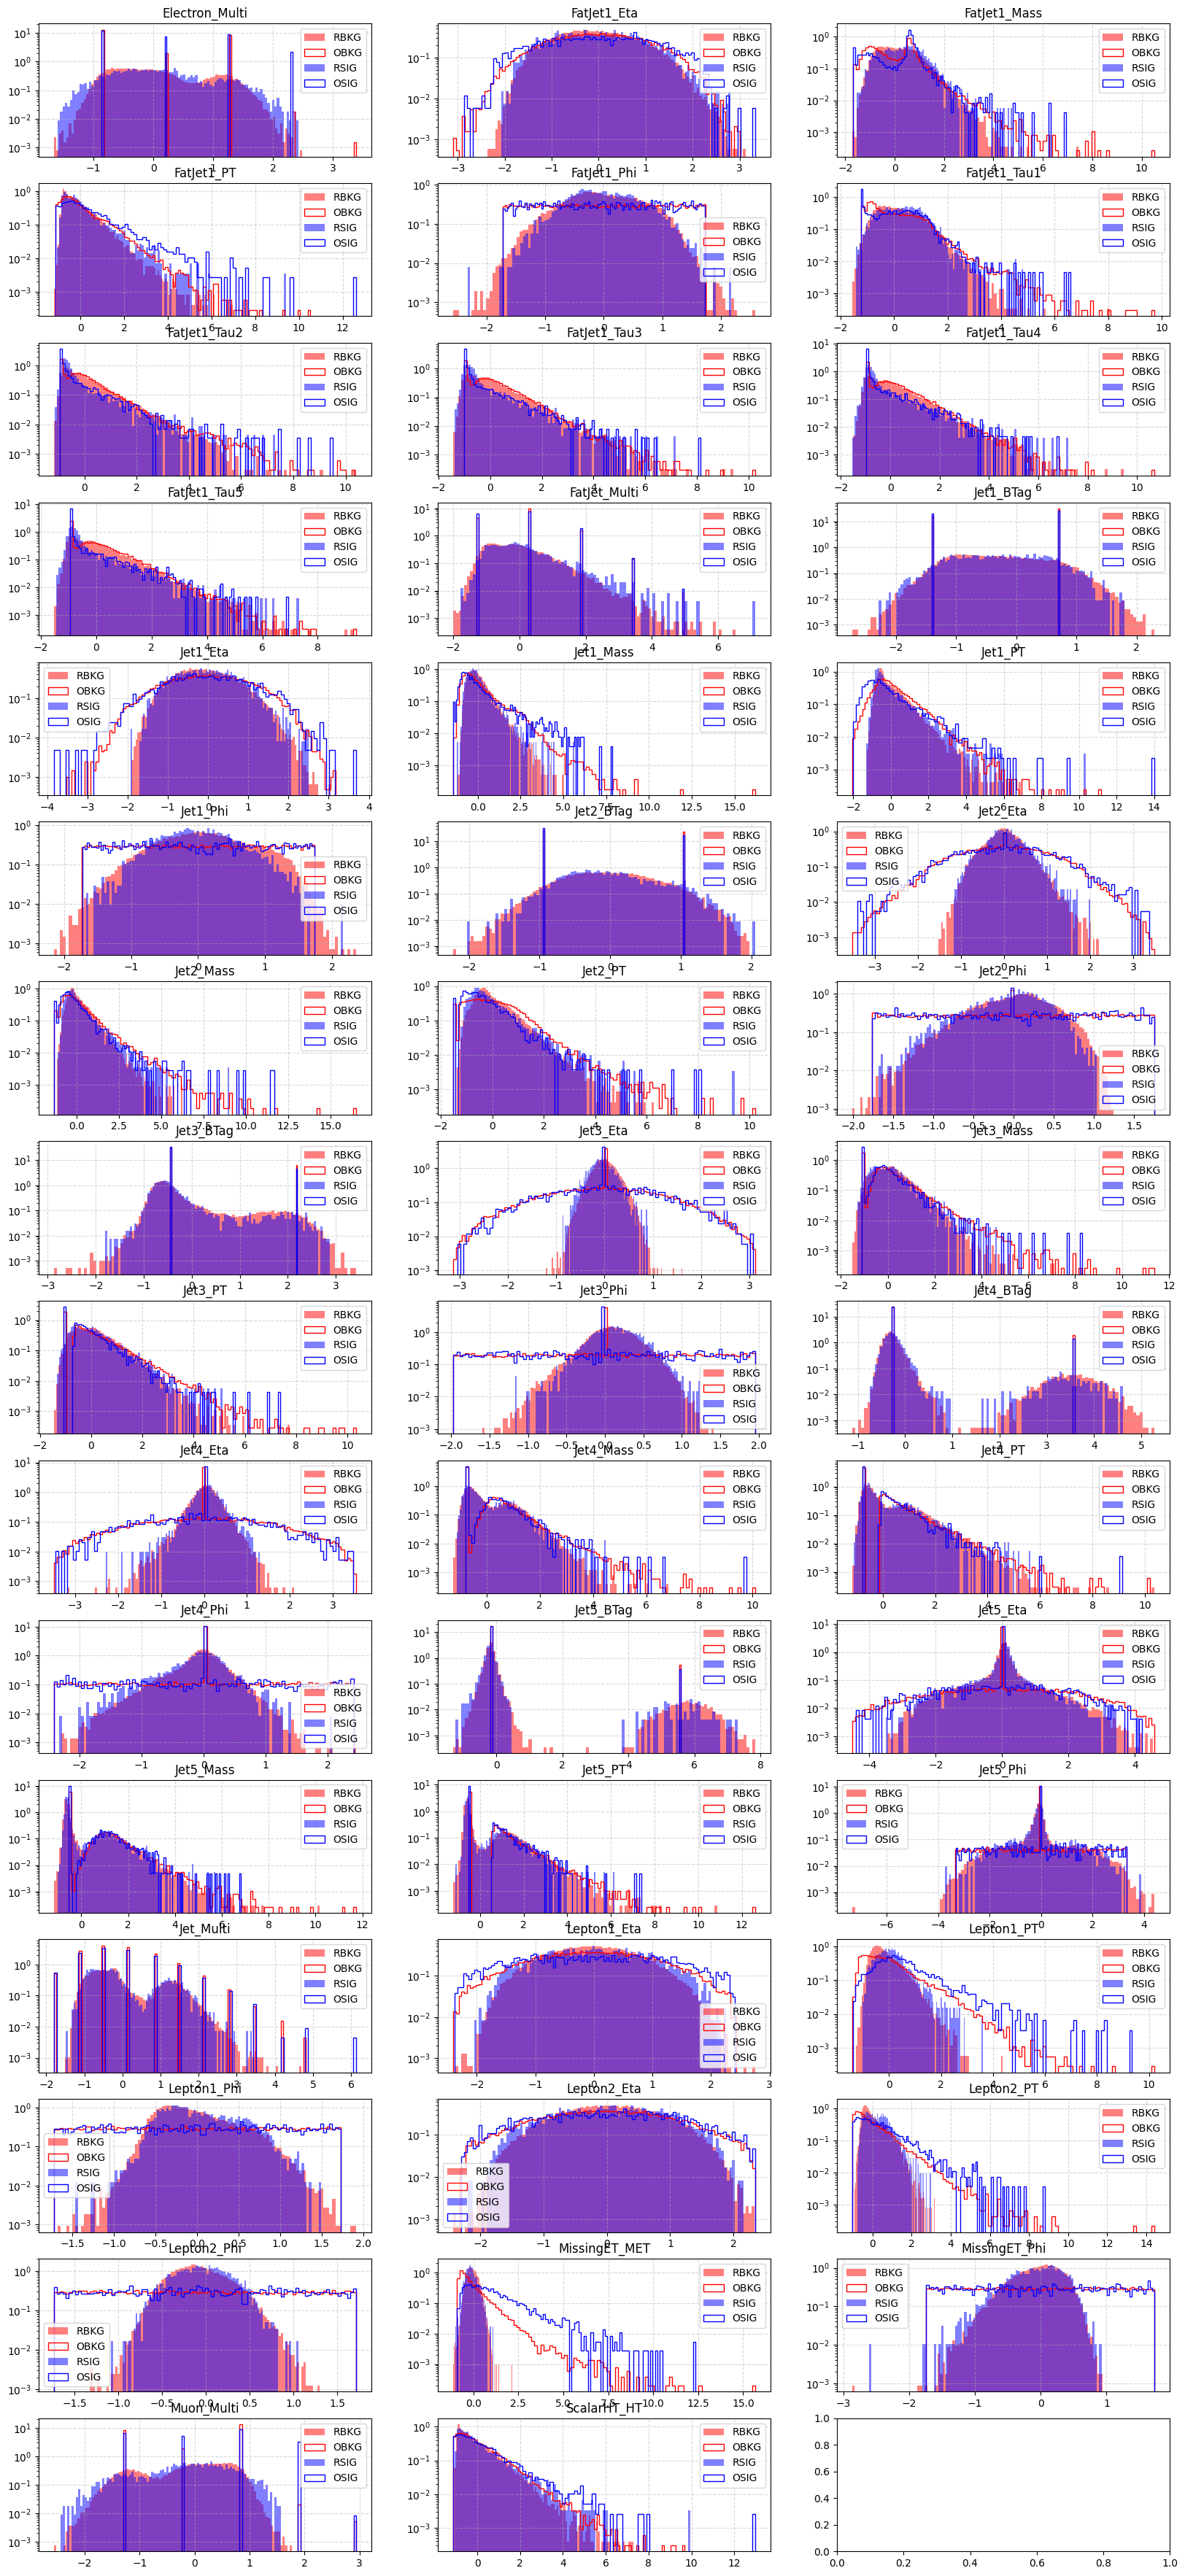

In [19]:
num_cols = 3
num_rows = len(features)//num_cols + 1

plt.clf()
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 240*num_cols//num_rows))
for idx, feature in enumerate(features):
    ax[idx//num_cols, idx%num_cols].grid(True, linestyle='--', alpha=0.5)
    ax[idx//num_cols, idx%num_cols].set_title(feature)
    ax[idx//num_cols, idx%num_cols].hist(df_recs[feature][y_test == BKG], bins=100, density=True, alpha=0.5, label="RBKG", color='red')
    ax[idx//num_cols, idx%num_cols].hist(df_orig[feature][y_test == BKG], bins=100, density=True, label="OBKG", histtype='step', color='red')
    ax[idx//num_cols, idx%num_cols].hist(df_recs[feature][y_test == SIG], bins=100, density=True, alpha=0.5, label="RSIG", color='blue')
    ax[idx//num_cols, idx%num_cols].hist(df_orig[feature][y_test == SIG], bins=100, density=True, label="OSIG", histtype='step', color='blue')
    ax[idx//num_cols, idx%num_cols].set_yscale("log")
    ax[idx//num_cols, idx%num_cols].legend()

plt.show()